In [458]:
import sqlite3 as sq
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import os
from functools import reduce
def polynomial(x, *args):
    return reduce(lambda acc, arg: acc + arg[1] * (x ** arg[0]), enumerate(args), 0)
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pickle

In [9]:
conn = sq.connect("../crowd.sqlite")

In [10]:
def list_tables(conn, filter_str: str = ""):
    with conn:
        tables = conn.execute("SELECT name FROM main.sqlite_master WHERE type='table'").fetchall();
    return list(filter(lambda t: t.find(filter_str) != -1, map(lambda t: t[0], tables)))

In [11]:
ballistic_tables = list_tables(conn, "fit_ballistic")
brownian_tables = list_tables(conn, "fit_brownian")

In [12]:
def get_table(conn, tables, isf = "brownian"):
    data = {t.replace(f"fit_{isf}_video_multiDDM", isf): {} for t in tables}
    for table in tables:
        table_name = table.replace(f"fit_{isf}_video_multiDDM", isf)
        with conn:
            raw_data = conn.execute(f"select * from {table}").fetchall()
        for d in raw_data:
            if isf == "brownian":
                _, box_size, q, tauc, _, A, _, B, _ = d
                try:
                    data[table_name][box_size][q] = (tauc, A, B)
                except KeyError:
                    data[table_name][box_size] = {q: (tauc, A, B)}
            else:
                _, box_size, q, tauc, _, v, _, A, _, B, _ = d
                try:
                    data[table_name][box_size][q] = (tauc, v, A, B)
                except KeyError:
                    data[table_name][box_size] = {q: (tauc, v, A, B)}
    return data
                
                

In [13]:
brownian_data = get_table(conn, brownian_tables)
ballistic_data = get_table(conn, ballistic_tables, "ballistic")

In [14]:
valid_keys = brownian_data[list(brownian_data.keys())[0]].keys()

In [15]:
def plot(data, box_size, param_name: str, param=0, vid=None):
    if vid is None:
        for name, dat in data.items():
            valid_box_sizes = list(dat.keys())
            closest_boxsize = valid_box_sizes[np.argmin(list(map(lambda x: abs(x - box_size), valid_box_sizes)))]
            x = list(dat[closest_boxsize].keys())
            y = list(map(lambda x: x[param], dat[closest_boxsize].values()))
            plt.title(f"All videos for boxsize = {closest_boxsize} pixels")
            plt.xlabel("log(q / pixel size)")
            plt.ylabel(f"log({param_name})")
            plt.plot(np.log(x), np.log(y))
    else:
        name = vid
        dat = data[name]
        valid_box_sizes = list(dat.keys())
        closest_boxsize = valid_box_sizes[np.argmin(list(map(lambda x: abs(x - box_size), valid_box_sizes)))]
        x = list(dat[closest_boxsize].keys())
        y = list(map(lambda x: x[param], dat[closest_boxsize].values()))
        plt.title(f"video = {name} for boxsize = {closest_boxsize} pixels")
        plt.xlabel("log(q / pixel size)")
        plt.ylabel(f"log({param_name})")
        plt.plot(np.log(x), np.log(y))


In [17]:
def plot_over_box_size(data, param_name: str, param=0, vid=None, fname=None):
    name = vid
    dat = data[name]
    for boxsize in dat.keys():
        x = list(data[name][boxsize].keys())
        y = list(map(lambda x: x[param], data[name][boxsize].values()))
        plt.title(f"{param_name} vs q / pixel size for {name} at all box sizes")
        plt.xlabel("log(q / pixel size)")
        plt.ylabel(f"log({param_name})")
        plt.plot(np.log(x), np.log(y), label=f"{boxsize} pixels")
    plt.legend(loc="best", bbox_to_anchor=(1.45, 1.08))
    if fname is not None:
        plt.savefig(fname, dpi=300, pad_inches=0.8, bbox_inches = "tight")


In [19]:
def save_all_over_boxsize(data, directory: str, param_name: str, param=0):
    if not os.path.exists(directory):
        os.mkdir(directory)
    for name in data.keys():
        output = f"{directory}/{name}_all_boxsizes.png"
        if os.path.exists(output):
            continue
        plot_over_box_size(data, param_name, param, name, output)
    

In [20]:
#tauc at fixed q for each box size
def transpose(data):
    output = {k: {} for k in data.keys()}
    for name, dat in data.items():
        for box_size, d in dat.items():
            for q, fits in d.items():
                try:
                    output[name][q][box_size] = fits
                except KeyError:
                    output[name][q] = {box_size: fits}
    return output

In [21]:
brownian_data_transposed = transpose(brownian_data)
ballistic_data_transposed = transpose(ballistic_data)

In [22]:
def boxsize_plot(data, name, q, param_name: str, param=0, fname=None):
    x = list(data[name][q].keys())
    y = list(map(lambda x: x[param], data[name][q].values()))
    plt.title(f"{param_name} vs boxsize / pixels for {name} at q = {q} / pixel size")
    plt.xlabel("log(boxsize / pixels)")
    plt.ylabel(f"log({param_name})")
    plt.plot(np.log(x), np.log(y))
    if fname is not None:
        plt.savefig(fname, dpi=300, pad_inches=0.8, bbox_inches = "tight")
    plt.close()

def boxsize_plot_all(data, folder: str,  param_name: str, param=0):
    if not os.path.exists(folder):
        os.mkdir(folder)
    for name, dat in data.items():
        for q in dat.keys():
            fname = f"{folder}/{name}_{q}.png"
            if os.path.exists(fname):
                continue
            boxsize_plot(data, name, q, param_name, param, fname)

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


OSError: [Errno 28] No space left on device

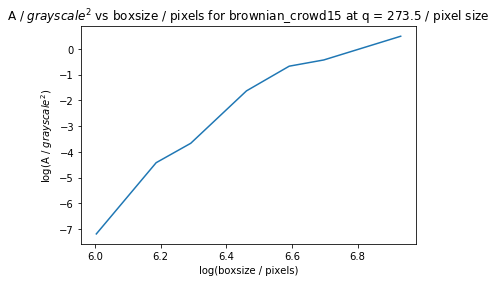

In [18]:
# save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_tauc", r"$\tau_c$ / (1 / fps)", 0)
# save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_A", r"A / $grayscale^2$", 1)
# save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_B", r"B / $grayscale^2$", 2)

# save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_tauc", r"$\tau_c$ / (1 / fps)", 0)
# save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_v", r"v / ($fps \cdot pixel$ $size$)", 1)
# save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_A", r"A / $grayscale^2$", 2)
# save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_B", r"B / $grayscale^2$", 3)

# boxsize_plot_all(brownian_data_transposed, "brownian_tauc_vs_boxsize", r"$\tau_c$ / (1 / fps)", 0)
# boxsize_plot_all(brownian_data_transposed, "brownian_A_vs_boxsize", r"A / $grayscale^2$", 1)
# boxsize_plot_all(brownian_data_transposed, "brownian_B_vs_boxsize", r"B / $grayscale^2$", 2)

# boxsize_plot_all(ballistic_data_transposed, "ballistic_tauc_vs_boxsize", r"$\tau_c$ / (1 / fps)", 0)
# boxsize_plot_all(ballistic_data_transposed, "ballistic_v_vs_boxsize", r"v / $(fps \cdot pixel size)$", 1)
# boxsize_plot_all(ballistic_data_transposed, "ballistic_A_vs_boxsize", r"A / $grayscale^2$", 2)
# boxsize_plot_all(ballistic_data_transposed, "ballistic_B_vs_boxsize", r"B / $grayscale^2$", 3)

In [232]:
#gradient of brownian tauc at each boxsize
def get_q_tauc(data, log_q_min = None, log_q_max = None):
    q = []
    tauc = []
    for a, b in data.items():
        if (log_q_min is None or np.exp(log_q_min) < a) and (log_q_max is None or a < np.exp(log_q_max)): 
            q.append(a)
            tauc.append(b[0])
    return q, tauc

def wait(): 
    while input("continue?") != "y": pass    

In [298]:
from typing import Dict, Tuple
def linear_region_extraction(existing: Dict[str, Dict[int, Tuple[float, float]]], threshold = 0.05, length_threshold = 5, only_size = None, order = None, linear_fit = False, vids=None):
    for video, data in brownian_data.items():
        if vids is not None and video not in vids:
            continue
        try:
            lin_regions = existing[video]
        except KeyError:
            existing[video] = {}
            lin_regions = existing[video]
        for box_size, dat in data.items():
            if box_size in lin_regions.keys() or (only_size is not None and only_size != box_size):
                continue
            q, tauc = get_q_tauc(dat)
            log_q_0, log_tauc_0 = np.log(q), np.log(tauc)
            low, high = get_endpoints(log_q_0, log_tauc_0, threshold, length_threshold)
            q, tauc = get_q_tauc(dat, low, high)
            log_q, log_tauc = np.log(q), np.log(tauc)
            %matplotlib inline
            plt.title(f"{video} at boxsize={box_size}")
            plt.xlabel("log(q / (1 / pixel size))")
            plt.ylabel(r"log($\tau_c$ / (1 / fps))")
            lin_regions[box_size] = (low, high)
            plt.plot(log_q_0, log_tauc_0, marker='o', label="Raw")
            if linear_fit and low is not None and high is not None:
                m, c, _, _, _ = linregress(log_q, log_tauc)
                plt.plot(log_q_0, m*log_q_0 + c, label=f"y = {round(m,2)}log(q) + {round(c,2)}")
            if order is not None:
                fit, _ = curve_fit(polynomial, log_q_0, log_tauc_0, p0=np.ones(order + 1))
                plt.plot(log_q_0, polynomial(log_q_0, *fit), label=f"{', '.join(map(lambda x: str(round(x, 2)), fit))}")
            plt.legend(loc="upper right")
            plt.show()
            low=input("low? ")
            high = input("high? ")
            lin_regions[box_size] = (low, high)

In [238]:
def get_endpoints(x, y, threshold = 0.05, length_thresh = 5):
    y_deriv = np.gradient(y)
    linear_regions = []
    for i, d1 in enumerate(y_deriv):
        for j, d2 in enumerate(y_deriv[i:]):
            if abs((d2 - d1)/d1) > threshold:
                if j >= length_thresh:
                    linear_regions.append((i, i + j - 1))
                break
            elif j + 1 == len(y_deriv[i:]) and j >= length_thresh:
                linear_regions.append((i, i + j))
    
    #remove overlaps
    linear_regions_no_overlap = []
    for reg1 in linear_regions:
        if not any([reg1[0] >= reg2[0] and reg1[1] <= reg2[1] for reg2 in linear_regions if reg2 != reg1]):
            linear_regions_no_overlap.append(reg1)
    if len(linear_regions_no_overlap) != 0:
        index_maxlength = np.argmax(np.array(list(map(lambda x: x[1] - x[0], linear_regions_no_overlap))))
        return list(map(lambda a: (x[a[0]], x[a[1]]), linear_regions_no_overlap))[index_maxlength]
    else:
        return (None, None)

In [408]:
from typing import Dict, Tuple
def get_linear_region(existing: Dict[str, Dict[int, Tuple[float, float]]], order=1, only_size = None, vids=None, autofit=False, threshold=0.05, length_thresh=5, show=True, folder = None):
    if folder is not None and not os.path.exists(folder):
        os.mkdir(folder)
    for video, data in brownian_data.items():
        if vids is not None and video not in vids:
            continue
        try:
            lin_regions = existing[video]
        except KeyError:
            existing[video] = {}
            lin_regions = existing[video]
        for box_size, dat in data.items():
            if box_size in lin_regions.keys() or (only_size is not None and only_size != box_size):
                continue
            q, tauc = get_q_tauc(dat)
            log_q, log_tauc = np.log(q), np.log(tauc)
            if autofit:
                low, high = get_endpoints(log_q, log_tauc, threshold, length_thresh)
            else:
                %matplotlib inline
                plt.title(f"{video} at boxsize={box_size}")
                plt.xlabel("log(q / (1 / pixel size))")
                plt.ylabel(r"log($\tau_c$ / (1 / fps))")
                plt.plot(log_q, log_tauc, marker='o', label="Raw")
                plt.show()
                try:
                    low = float(input("low? "))
                    high = float(input("high? "))
                except ValueError:
                    low = None
                    high = None
            q_lin, tauc_lin = get_q_tauc(dat, low, high)
            log_q_lin, log_tauc_lin = np.log(q_lin), np.log(tauc_lin)
            fit, _ = curve_fit(polynomial, log_q_lin, log_tauc_lin, p0=np.ones(order + 1))
            if show:
                plt.plot(log_q_lin, log_tauc_lin, marker='o')
                plt.plot(log_q_lin, polynomial(log_q_lin, *fit), label=f"{' + '.join(map(lambda x: str(round(x[1], 2)) + (f'x^{x[0]}' if x[0] != 0 else ''), enumerate(fit)))}")
                plt.legend(loc="best", bbox_to_anchor=(1.03, -0.2))
                plt.show()
                while(input("Happy? ") != "y"):
                    try:
                        low = float(input("low? "))
                        high = float(input("high? "))
                    except ValueError:
                        low = None
                        high = None
                    q_lin, tauc_lin = get_q_tauc(dat, low, high)
                    log_q_lin, log_tauc_lin = np.log(q_lin), np.log(tauc_lin)
                    plt.plot(log_q_lin, log_tauc_lin, marker='o')
                    fit, _ = curve_fit(polynomial, log_q_lin, log_tauc_lin, p0=np.ones(order + 1))
                    plt.plot(log_q_lin, polynomial(log_q_lin, *fit), label=f"{' + '.join(map(lambda x: str(round(x[1], 2)) + (f'x^{x[0]}' if x[0] != 0 else ''), enumerate(fit)))}")
                    plt.legend(loc="best", bbox_to_anchor=(1.03, -0.2))
                    plt.show()
            else:
                plt.title(f"{video} at boxsize={box_size}")
                plt.xlabel("log(q / (1 / pixel size))")
                plt.ylabel(r"log($\tau_c$ / (1 / fps))")
                plt.plot(log_q_lin, log_tauc_lin, marker='o')
                plt.plot(log_q_lin, polynomial(log_q_lin, *fit), label=f"{' + '.join(map(lambda x: str(round(x[1], 2)) + (f'x^{x[0]}' if x[0] != 0 else ''), enumerate(fit)))}")
                plt.legend(loc="best", bbox_to_anchor=(1.03, -0.2))
                plt.savefig(f"{folder}/{video}_boxsize_{box_size}.png", dpi=300, pad_inches=0.8, bbox_inches = "tight")
                plt.close()
            
            lin_regions[box_size] = (low, high, fit)
        print(f"Finished {video}")

In [453]:
def plot_tauc_boxsize(data, show=True, folder = None):
    if not show and not os.path.exists(folder):
        os.mkdir(folder)
    for video, dat in data.items():
        box_sizes = []
        leading_order = []
        for boxsize, fit in dat.items():
            params = fit[2]
            if len(leading_order) == 0:
                leading_order = [[] for _ in range(len(params))]
            box_sizes.append(boxsize)
            for j, p in enumerate(params):
                leading_order[j].append(p)
        plt.title(fr"{video} - polynomial fit $O(log^{len(params) - 1}q)$")
        plt.xlabel("Box size / pixels")
        plt.ylabel("Parameter")
        for i, f in enumerate(leading_order):
            plt.plot(box_sizes, f, marker='o', label=(fr"O($log^{i}q$)" if i != 0 else "O(1)"))
        plt.legend(loc="best", bbox_to_anchor=(1.3, 1.0))
        if show:
            plt.show()
            wait()
        else:
            plt.savefig(f"{folder}/{video}_fit_poly{len(params) - 1}.png", dpi=300, pad_inches=0.8, bbox_inches = "tight")
        plt.close()
        print(f"Saved param plot for {video}")

In [457]:
def plot_all(order = 5):
    existing = {}
    get_linear_region(existing, order, autofit = True, threshold=10**30, show=False, folder=f"tauc_Order{order}PolyFit")
    with open(f"tauc_Order{order}_autofit_vs_boxsize.pickle", "wb") as f:
        pickle.dump(existing, f)
    plot_tauc_boxsize(existing, show = False, folder=f"polyfit{order}_param_v_boxsize")